In [1]:
%load_ext autoreload
%autoreload 2

from experiment import Experiment

In [1]:
import torch
torch.cuda.is_available()

True

In [3]:
exp_name = 'v2'
print("Running Experiment: ", exp_name)
exp = Experiment(exp_name)

Running Experiment:  v2


start epoch: 0


Epoch 0/3:   0%|          | 0/31795 [00:00<?, ?img/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

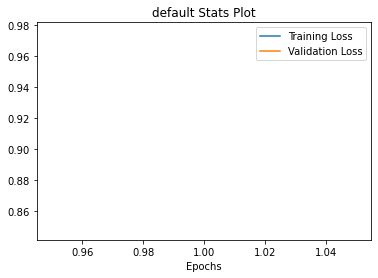

Epoch: 1, Train Loss: 0.8475398464890632, Val Loss: 0.9754939079284668,Took 0:49:45.609745, ETA: 1:39:31.219490

start epoch: 1


Epoch 1/3:   0%|          | 0/31795 [00:00<?, ?img/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

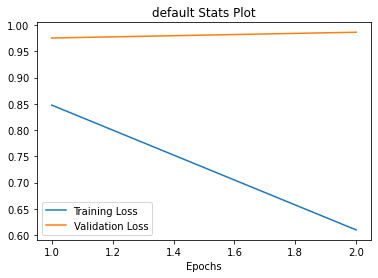

Epoch: 2, Train Loss: 0.609614042200852, Val Loss: 0.9865006804466248,Took 0:49:58.562493, ETA: 0:49:58.562493

start epoch: 2


Epoch 2/3:   0%|          | 0/31795 [00:00<?, ?img/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

Validation round:   0%|          | 0/451 [00:00<?, ?batch/s]

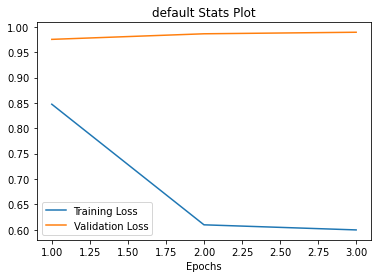

Epoch: 3, Train Loss: 0.5995520094098168, Val Loss: 0.9895434379577637,Took 0:50:06.235647, ETA: 0:00:00



In [4]:
#torch.backends.cudnn.deterministic = True
exp.run()

In [8]:
exp.generate()

  0%|          | 0/600 [00:00<?, ?it/s]

In [7]:
exp.generate()

  0%|          | 0/600 [00:00<?, ?it/s]

In [8]:
import os
import csv
import trimesh
from trimesh.exchange.dae import load_collada
from trimesh.resolvers import FilePathResolver
from trimesh.sample import sample_surface
import open3d
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils
from numpy.linalg import inv

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def to_homog(points):
    # N: number of points
    ones = np.ones((points.shape[0],1))
    points_homog = np.concatenate([points, ones], axis=-1)
    return points_homog
def rand_rotation_matrix():
    # based on http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    a, b, c = np.random.uniform(size=(3,))
    
    a = a* 2 * np.pi
    b = b* 2 * np.pi
    c = c * 2.0
    
    r = np.sqrt(c)
    V = (
        np.sin(b) * r,
        np.cos(b) * r,
        np.sqrt(2.0 - c)
        )
    
    # http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    st = np.sin(a)
    ct = np.cos(a)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M

In [9]:
test_path = 'D:/291dataset/testing_data_final(2022)/testing_data_final/v2.2/'
label_path = 'D:/Pytorch-UNet-master/generation/v2/'
path = 'D:/291dataset'

In [10]:
test_prefix = np.unique([x.split('_')[0] for x in os.listdir(test_path)])

In [11]:
def init_trans_20(source, target):
    trans_list = []
    translation = target.get_center() - source.get_center()
    trans_init = np.asarray([[1.0, 0.0, 0.0, translation[0]],
                        [0.0, 1.0, 0.0, translation[1]],
                        [0.0, 0.0, 1.0, translation[2]],
                        [0.0, 0.0, 0.0, 1.0]])
    trans_list.append(trans_init)
    for _ in range(19):
        init_rotation = rand_rotation_matrix()
        rt = np.concatenate([init_rotation, translation.reshape(1,-1).T], axis=1)
        trans_init = np.concatenate([rt, np.array([[0.0, 0.0, 0.0, 1.0]])], axis=0) 
        trans_list.append(trans_init)
    
    return trans_list

In [14]:
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
#crop = transforms.CenterCrop((450, 800))

out = {}
threshold = 0.3
for p in tqdm(test_prefix):
    #rgb_test = test_path + p + "_color_kinect.png" 
    depth_test = test_path + p + "_depth_kinect.png" 
    label_test = label_path + p + "_label_kinect.png" 
    meta_test = test_path + p + "_meta.pkl" 
    
    #rgb = np.array(Image.open(rgb_test)) / 255   # convert 0-255 to 0-1
    depth = np.array(Image.open(depth_test)) / 1000   # convert from mm to m
    label = np.array(Image.open(label_test))
    meta = load_pickle(meta_test)
    
    values = []
    name_id = 0
    for i in range(79):
        if i not in meta['object_ids']:
            values.append(None)
        else:
            name = meta['object_names'][name_id]
            
            intrinsic = meta['intrinsic']
            extrinsic = meta['extrinsic']
            
            z = depth
            v, u = np.indices(z.shape)
            uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
            points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  
            viewer_points = to_homog(points_viewer.reshape(-1, 3))
            world_points = viewer_points @ np.linalg.inv(extrinsic).T
            world_points = world_points[:, :3]
            label = label.reshape(-1)
            indices = np.nonzero(label == i)
            world_points_object = world_points [indices]
            #object_colors = rgb.reshape([-1, 3])[indices]
            
            points = open3d.utility.Vector3dVector(world_points_object) 
            #colors = open3d.utility.Vector3dVector(object_colors)
            source  = open3d.geometry.PointCloud()
            source.points = points
            #source.colors = colors

            model_dir = path + '/models/' + name
            mesh_path = os.path.join(model_dir, 'visual_meshes', 'visual.dae')
            resolver = FilePathResolver(os.path.join(model_dir, 'visual_meshes'))
            data = load_collada(mesh_path, resolver)
            geometry = data['geometry'][data['graph'][0]['geometry']]
            mesh = trimesh.Trimesh(**geometry)
            
            target = open3d.geometry.PointCloud()
            target_points, _ = sample_surface(mesh, 1024)
            target.points = open3d.utility.Vector3dVector(target_points * meta['scales'][i]) 

            best_rmse = 10000
            best_iter = None
            
            trans_list = init_trans_20(source, target)
            #translation = target.get_center() - source.get_center()

            for begin_trans in trans_list:
                threshold = 1
                iter1 = open3d.pipelines.registration.registration_icp(
                    source, target, threshold, begin_trans,
                    open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                    open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20))

                threshold = 0.2
                iter2 = open3d.pipelines.registration.registration_icp(
                    source, target, threshold, iter1.transformation,
                    open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                    open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=500))

                if iter2.inlier_rmse < best_rmse:
                    best_iter = iter2
                    best_rmse = iter2.inlier_rmse
          
            T = best_iter.transformation
            values.append(inv(T).tolist())
            name_id += 1
            
    inner = {'poses_world': values}
    out[p] = inner 

  0%|          | 0/600 [00:00<?, ?it/s]

In [15]:
import json
with open('v2_hw3_2layer.json', 'w') as outfile: 
    json.dump(out, outfile)

In [16]:
z_180 = np.array([[1, 0, 0],
                  [0, 1, -np.sin(np.pi)], 
                  [0, 0, np.cos(np.pi)]] )
z_90 = np.array([[1, 0, 0],
                  [0, 1, -np.sin(np.pi/2)], 
                  [0, 0, np.cos(np.pi/2)]] )
z_270 = np.array([[1, 0, 0],
                  [0, 1, -np.sin(np.pi * 3 / 2)], 
                  [0, 0, np.cos(np.pi *3 / 2)]] )

In [17]:
z_axis = [z_180, z_90, z_270]

In [ ]:
from tqdm.notebook import tqdm
out = {}
threshold = 1
voxel_size = 0.01
pause = 1.43e-3
def init_trans_20(source, target):
    trans_list = []
    translation = target.get_center() - source.get_center()
    trans_init = np.asarray([[1.0, 0.0, 0.0, translation[0]],
                        [0.0, 1.0, 0.0, translation[1]],
                        [0.0, 0.0, 1.0, translation[2]],
                        [0.0, 0.0, 0.0, 1.0]])
    trans_list.append(trans_init)
    for _ in range(19):
        init_rotation = rand_rotation_matrix()
        rt = np.concatenate([init_rotation, translation.reshape(1,-1).T], axis=1)
        trans_init = np.concatenate([rt, np.array([[0.0, 0.0, 0.0, 1.0]])], axis=0) 
        trans_list.append(trans_init)
    
    return trans_list

for p in tqdm(test_prefix):
    depth_test = test_path + p + "_depth_kinect.png"
    label_test = label_path + p + "_label_kinect.png"
    meta_test = test_path + p + "_meta.pkl"

    depth = np.array(Image.open(depth_test)) / 1000
    label = np.array(Image.open(label_test))
    meta = load_pickle(meta_test)

    values = []
    name_id = 0
    for i in range(79):
        if i not in meta['object_ids']:
            values.append(None)
        else:
            name = meta['object_names'][name_id]

            intrinsic = meta['intrinsic']
            extrinsic = meta['extrinsic']
            z = depth
            v, u = np.indices(z.shape)
            uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
            points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]
            viewer_points = to_homog(points_viewer.reshape(-1, 3))
            world_points = viewer_points @ np.linalg.inv(extrinsic).T
            world_points = world_points[:, :3]
            indices = np.nonzero(label.reshape(-1) == i)
            world_points_object = world_points[indices]

            points = open3d.utility.Vector3dVector(world_points_object * (1 / meta['scales'][i]))
            source = open3d.geometry.PointCloud()
            source.points = points

            model_dir = path + '/models/' + name
            mesh_path = os.path.join(model_dir, 'visual_meshes', 'visual.dae')
            resolver = FilePathResolver(os.path.join(model_dir, 'visual_meshes'))
            data = load_collada(mesh_path, resolver)
            geometry = data['geometry'][data['graph'][0]['geometry']]
            mesh = trimesh.Trimesh(**geometry)

            target = open3d.geometry.PointCloud()
            target_points, _ = sample_surface(mesh, 1024)
            target.points = open3d.utility.Vector3dVector(target_points)

            best_rmse = 10000
            best_iter = None

            trans_list = init_trans_20(source, target)
            translation = target.get_center() - source.get_center()

            for begin_trans in trans_list:
                threshold = 1
                iter1 = open3d.pipelines.registration.registration_icp(
                    source, target, threshold, begin_trans,
                    open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                    open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20))

                threshold = 0.2
                iter2 = open3d.pipelines.registration.registration_icp(
                    source, target, threshold, iter1.transformation,
                    open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                    open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=500))

                if iter2.inlier_rmse < best_rmse:
                    best_iter = iter2
                    best_rmse = iter2.inlier_rmse

                iter1_r = iter1.transformation[:3, :3]
                for z_r in z_axis:
                    new_r = z_r @ iter1_r
                    rt = np.concatenate([new_r, translation.reshape(1, -1).T], axis=1)
                    trans_init = np.concatenate([rt, np.array([[0.0, 0.0, 0.0, 1.0]])], axis=0)

                    threshold = 0.2
                    iter2 = open3d.pipelines.registration.registration_icp(
                        source, target, threshold, trans_init,
                        open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                        open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=500))
    
                    if iter2.inlier_rmse < best_rmse:
                        best_iter = iter2
                        best_rmse = iter2.inlier_rmse
            try:
                result = inv(best_iter.transformation)
            except:
                result = inv(best_iter.transformation + 0.00001*np.random.rand(4, 4))
            
            values.append(result.tolist())
            name_id += 1

    inner = {'poses_world': values}
    out[p] = inner

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
import json
with open('v2_layer18090.json', 'w') as outfile: 
    json.dump(out, outfile)

In [8]:
pred.shape

(225, 400)

In [9]:
pred

array([[80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80],
       ...,
       [80, 80, 80, ..., 81, 81, 81],
       [80, 80, 80, ..., 81, 81, 81],
       [80, 80, 80, ..., 81, 81, 81]], dtype=int64)

In [15]:
import numpy as np
im = Image.fromarray(pred.astype(np.uint8))
#im.save("filename.jpeg")

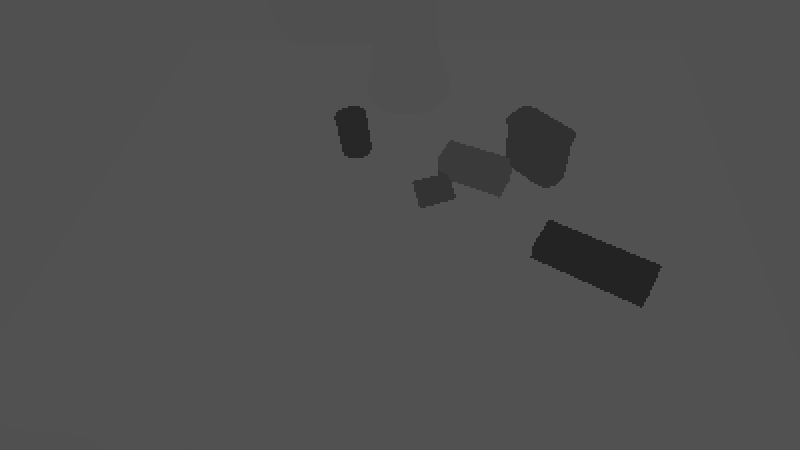

In [46]:
from PIL import Image
im.resize((800, 450), resample=Image.NEAREST)

In [17]:
im.save("test.png")

In [9]:
exp.test()

0it [00:00, ?it/s]

mIOU for class class_choice: 0.8631334694100762


In [10]:
pred, target = exp.generate()

0it [00:00, ?it/s]

[ 3  8 30 31 35 42 44 47 48 49 51 52 55 56 58 59 60 61 62 63 64 65 67 68
 69 70 72 73 75 79 80 81]


In [11]:
target = target[0]

In [12]:
pred = pred[:2000]

In [13]:
pred.shape

(2000, 82)

In [15]:
import numpy as np
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

{14: 8, 30: 11, 51: 7, 52: 11, 58: 28, 79: 144, 80: 3232, 81: 1559}

In [16]:
np.unique(np.argmax(pred, axis=1))

array([30, 35, 47, 51, 52, 55, 58, 79, 80, 81], dtype=int64)

In [18]:
import numpy as np
np.unique(np.argmax(pred, axis=1))

array([79, 80, 81], dtype=int64)

In [50]:
del exp
import gc
gc.collect() 

32061